<a href="https://colab.research.google.com/github/yajima-yasutoshi/DataMining2024/blob/main/20241210/%E5%88%86%E9%A1%9E.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#分類


## データマイニング第11回（20241210）
https://github.com/yajima-yasutoshi/DataMining2024/tree/main/20241210


#本日の講義の目的

分類手法に関する説明を行う。特に、ロジスティック回帰による予測モデルの構築法を理解する。

## 分類手法が活用されるシーン

* 解約、離脱の予測
> 携帯電話や動画配信サービスなどのサブスクリプションサービスでは、
会員数の維持拡大がビジネス上非常に重要である。
会員の維持を目的とした場合、
将来解約する可能性を会員ごとに予測し、
解約しそうな顧客に対しのみさまざまな施策、
例えば、クーポンによる割引などを実施することで、
効率よく解約を未然に防ぐ施策が盛んに行われている。
会員の属性やサービスの利用傾向をデータ化して
解約の可能性を予測する取り組みが広く行われている。


* 病気の診断
> 検査の結果や過去の病歴などから病気にかかっているのか/いないのか、
あるいは将来の発病を予測することにデータの活用が盛んに行われている。
近年は画像データを使った予測も行われている。

* 倒産や破産の予測
> 金融機関で融資を行う際には、借り手が返済可能かそうでないかを判断する。
個人向けの融資であれば、個人の属性や年収、職業といったデータが使われ、
あるいは、企業向けの融資であれば、さまざまな財務指標データを使った
予測が広く行われている。

* 不正検知
> クレジットカード利用や金融取引などでは、
正当な利用か不正な利用か判断し、
自動的に利用を制限するシステムが導入されている。
こういったシステムには、
取引に関するデータを使った予測モデルが組み込まれている。

この例のように、ある事象の発生するかしないかを予測する問題を
**2値の分類問題**と呼び、代表的なAIモデルが
**ロジスティック回帰**である。

重回帰では人数や売上個数といった数値予測を扱ったが、
ここで扱うロジスティック回帰は2値の分類を行うモデルを
構築する代表的な手法である。


### 【参考】ロジスティック回帰ライブラリー
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

# 環境の準備

まず初めに、日本語を表示するための準備と
分析に必要なライブラリーのインポートを行うため、
以下のセルを実行する。

In [ ]:
# インストール
!pip install japanize-matplotlib

# 必要なライブラリをインポート
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import japanize_matplotlib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 分類（ロジスティック回帰）に必要なライブラリー
from sklearn.linear_model import LogisticRegression

# その他必要なライブラリー
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# データの準備

sklearn ライブラリーに格納されている
cancer data と呼ばれるサンプルデータを使い、
ロジスティック回帰の説明を行う。

以下のセルでは、
データを読み込みデータフレーム変数 df に格納
する操作を行っている。

In [ ]:
from sklearn.datasets import load_breast_cancer

cancer = load_breast_cancer()
df = pd.DataFrame(cancer.data, columns = cancer.feature_names)
df['diagnosis'] = cancer.target
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

これは、癌の疑いのある細胞に関連した30項目（サイズ、形状、など細胞の状態）の情報と、そこから医師などが判断した診断結果（'diagnosis'）のデータである。

このデータでは全ての項目は数値型となっており、
また、欠損値もないことが確認できる。
特に診断結果（'diagnosis'）は

* 悪性の場合には 0
* 良性の場合には 1

が入力されており、
このような項目を**2値**の項目と呼ぶ。

このデータを学習させて、
細胞に関する30項目を説明変数として
**癌の診断（良性か悪性かの分類）を行うAIを構築**する。

##基礎集計

まず初めに、
目的変数となる diagnosis の分布の確認する。

<Axes: xlabel='count', ylabel='diagnosis'>

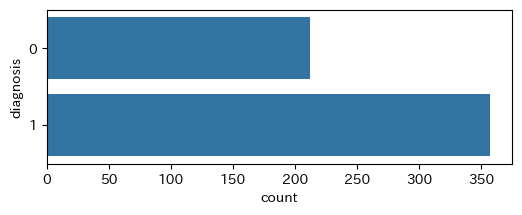

In [ ]:
plt.figure(figsize=(6, 2))
sns.countplot(y='diagnosis', data=df)

diagnosis は数値型の項目ではあるが、値は 0 と 1 の2値となっていることが確かめられる。分類問題の目的変数として用いることができる。

ヒストグラムを作成して、各項目の分布を確認する。

<Axes: xlabel='mean radius', ylabel='Count'>

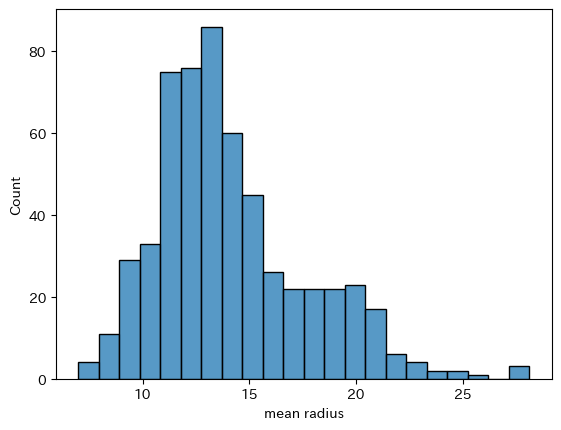

In [ ]:
sns.histplot(data=df, x='mean radius')

hue を使い目的変数（diagnosis）で色分けする。

<Axes: xlabel='mean radius', ylabel='Count'>

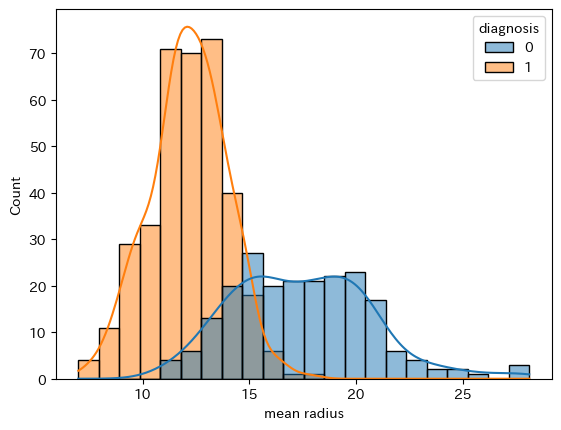

In [ ]:
sns.histplot(data=df, x='mean radius', hue='diagnosis', kde=True)

このグラフからは、mean radius がおよそ18を超えるとほぼ全てが悪性、
逆に10を下回るとほぼ全てが良性になっていることが分かる。

一方で、10から18の間では、良性も悪性もあり、
この項目だけでは細胞が悪性か良性かを判断できないことが分かる。

<Axes: xlabel='radius error', ylabel='Count'>

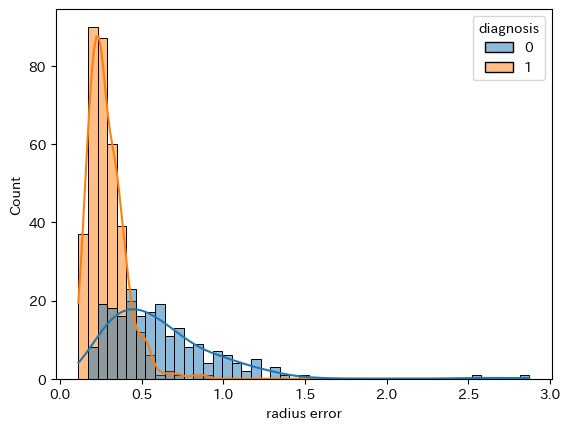

In [ ]:
sns.histplot(data=df, x='radius error', hue='diagnosis', kde=True)

<Axes: xlabel='mean compactness', ylabel='Count'>

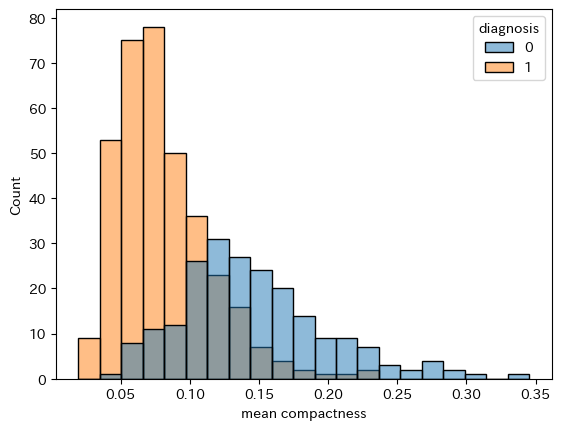

In [ ]:
# sns.histplot(data=df, x='fractal dimension error', hue='diagnosis', kde=True)
sns.histplot(data=df, x='mean compactness', hue='diagnosis')

<Axes: xlabel='mean area', ylabel='Count'>

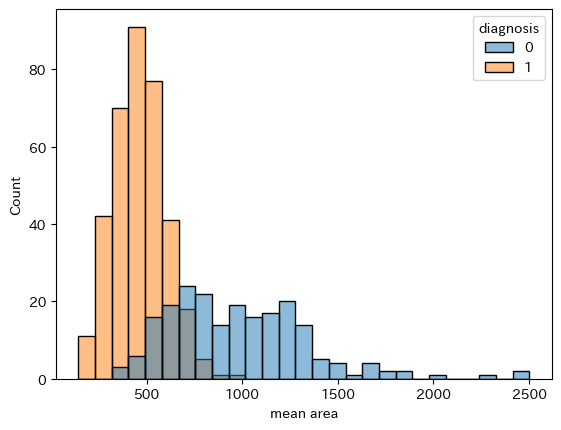

In [ ]:
sns.histplot(data=df, x='mean area', hue='diagnosis')
# sns.boxplot(data=df, y='mean area')

# ロジスティック回帰
30項目の数値データと癌の診断結果（diagnosis）から、
悪性か良性かを分類するAIを構築する。

悪性か良性かといった2値の分類を行いたい場合に用いられる手法として、
最も基本となる**「ロジスティック回帰」**の使い方を説明する。

### ロジスティックモデル構築全体の流れ

ロジスティックモデル構築の流れは以下のようになる。

1. 変数の設定

  説明変数と目的変数を設定する。

2. データの分割

  データ全体を、学習用データと評価用データに分割する。
    train_test_split() を利用する。

3. 説明変数の標準化

  変数の平均を0、分散を1に標準化する。
  StandardScaler の fit() と transform() を使うことで実現される。

4. モデルの学習

   学習用データを用いてモデルを構築する。fit() を使う。

5. 評価用データでモデルの精度を評価

   1. 評価用の説明変数で予測を行う。predict() を使う。
   2. 予測と正解を比較して精度を求める。accuracy_score() を使う。



## 変数の設定
* **説明変数：** 予測する元になる項目。上のデータでは30項目の数値型データがある。
* **目的変数：** 予測の対象となる項目。上のデータでは diagnosis である。

ロジスティック回帰を適用するためには、

* 説明変数が数値型のデータで、かつ
* 目的変数が2値の項目（カテゴリ変数、数値型変数どちらでも良い）

となる必要がある。
上で準備したデータはこの条件を満足している。


説明変数と目的変数をそれぞれ変数 X と y にセットする。

In [ ]:
X = df[ ['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error', 'fractal dimension error',
       'worst radius', 'worst texture', 'worst perimeter', 'worst area',
       'worst smoothness', 'worst compactness', 'worst concavity',
       'worst concave points', 'worst symmetry', 'worst fractal dimension']]
y = df[['diagnosis']]

30項目全てを使うため多くの項目を記述する必要があるが、
以下のようにすることもできる。

In [ ]:
# 項目'diagnosis'は変数dfの最後にある項目なので、それを除くと説明変数のみとなる
X = df.iloc[:,:-1]
y = df[['diagnosis']]

あるいは、drop を使うことも可能である。
列削除は以下のように実行する。


In [ ]:
X = df.drop(['diagnosis'], axis=1)

列を削除する場合は
```
axis=1
```
が必要である。

## データの分割

予測モデルの精度を事前に確認するために、以下のように全データを「学習用データ」と「検証用データ」にランダム分け、
学習用データでモデルを構築したのちに、
検証用データで精度
（今回の例では、AIの予測が医師の判断とどの程度一致するか）
を確認することが一般的である。

```
train_test_split
```
を用いると、データを学習用と検証用に分割することができる。
一般的には検証用のレコード数は、
全体の **2割** 程度が適切とされている。

検証用のレコードの割合を2割にする場合は以下のように指定する。
```
test_size=0.2
```


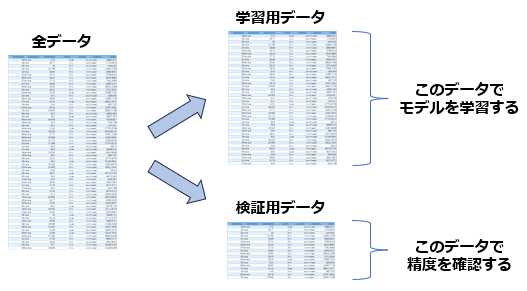

 train_test_split を用いることで、
説明変数 X と目的変数 y から
学習用データと検証用データが作成できる。

```
A, B, C, D  = train_test_split(X, y, test_size=0.2, random_state=0)
```

A, B, C, Dは以下のようにセットされる。

データ | 説明変数  | 目的変数
--     | --        | --
学習用データ | A   | C
検証用データ | B   | D

In [ ]:
# 必要なライブラリのインポート
from sklearn.model_selection import train_test_split

# データを学習用データと検証用に分割
# test_size は、0.2 から 0.3 程度が良いとされる
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

shape を使ってレコード数を確認する。

In [ ]:
X.shape

(569, 30)

In [ ]:
X_train.shape

(455, 30)

## 説明変数の標準化

ロジスティック回帰では、説明変数の標準化が必要とされる。

> 標準化とは、データを変換して、平均 0、分散 1 にすることである。

標準化は、
StandardScaler の fit() と transform() を使うことで実現される。

In [ ]:
# 必要なライブラリのインポート
from sklearn.preprocessing import StandardScaler

# 準備のための手順
scaler = StandardScaler()
scaler.fit(X_train) #学習用のデータで標準化の設定を行う

# 標準化後のものは別の変数にセットすると良い
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)

X_train_scaled では数値が標準化されたことを確認する。

In [ ]:
# X_train_scaled では数値が標準化されたことを確認する
pd.DataFrame(X_train_scaled, columns=X_train.columns).describe()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
count,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,...,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02
mean,-9.135549e-16,-3.341893e-15,3.216963e-15,-2.201902e-15,-1.456222e-15,5.348591e-16,6.871182e-16,4.450652e-16,-5.669702e-15,6.715019e-16,...,-4.841060e-16,4.841060e-16,-1.460126e-15,1.249306e-16,5.936155e-15,-3.708877e-16,-1.358620e-15,2.654775e-16,-2.137484e-15,1.989129e-15
std,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,...,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00
min,-2.019404e+00,-2.272988e+00,-1.977589e+00,-1.426379e+00,-3.176344e+00,-1.664312e+00,-1.125696e+00,-1.262871e+00,-2.738225e+00,-1.865718e+00,...,-1.704360e+00,-2.218398e+00,-1.673608e+00,-1.188201e+00,-2.711807e+00,-1.468356e+00,-1.341360e+00,-1.754014e+00,-2.128278e+00,-1.598903e+00
25%,-6.873871e-01,-7.420774e-01,-6.883840e-01,-6.577342e-01,-7.082998e-01,-7.367713e-01,-7.403181e-01,-7.254573e-01,-6.975035e-01,-7.022156e-01,...,-6.624319e-01,-7.439783e-01,-6.767688e-01,-6.257607e-01,-7.105576e-01,-6.807320e-01,-7.569093e-01,-7.585201e-01,-6.518526e-01,-6.814765e-01
50%,-2.357361e-01,-9.697672e-02,-2.403944e-01,-3.131017e-01,-3.433938e-02,-2.188714e-01,-3.517235e-01,-3.963173e-01,-6.354630e-02,-1.656097e-01,...,-2.878293e-01,-5.394673e-02,-2.932556e-01,-3.516681e-01,-3.801757e-02,-2.619431e-01,-1.970300e-01,-2.427267e-01,-1.416994e-01,-2.181271e-01
75%,4.551909e-01,5.866375e-01,4.871769e-01,3.009759e-01,6.519540e-01,5.151506e-01,4.775784e-01,6.589276e-01,5.320447e-01,4.590848e-01,...,4.409060e-01,6.229571e-01,5.074669e-01,2.583182e-01,5.659411e-01,5.435962e-01,5.549081e-01,7.103914e-01,4.542741e-01,4.568064e-01
max,3.963628e+00,3.528104e+00,3.980919e+00,5.163006e+00,3.503046e+00,4.125777e+00,4.366097e+00,3.955644e+00,4.496561e+00,5.105021e+00,...,4.049783e+00,3.938555e+00,4.261315e+00,5.758096e+00,3.988374e+00,5.270909e+00,4.936910e+00,2.695096e+00,5.934052e+00,6.968987e+00


mean_redius の平均が

-9.135549e-16

と表示されている。これは、

$-9.135549 \times 10^{-16}$

という意味である。計算誤差の範囲であり 0 と判断する。

いずれの項目も平均が 0、標準偏差が 1.0 になっていることが確認できる。

##ロジスティック回帰モデルの学習

学習を行う関数は回帰と同様に fit であり、以下のように用いる

```
model = LogisticRegression()
model.fit(説明変数, 目的変数)
```



In [ ]:
# 分類（ロジスティック回帰）に必要なライブラリー
from sklearn.linear_model import LogisticRegression

# ロジスティック回帰モデルの準備のための命令
model = LogisticRegression()

# モデルを学習
model.fit(X_train_scaled, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression()

### 参考

上の例では警告メッセージが表示されるが特に問題はない。
以下のようにプログラムすることで警告メッセージが出力されなくなる。

In [ ]:
# モデルを学習
model.fit(X_train_scaled, y_train.values.ravel()  )

LogisticRegression()

線形回帰と同様、回帰係数が model.coef_ により得られる。

In [ ]:
model.coef_

array([[-0.3512559 , -0.488908  , -0.34062564, -0.4075774 , -0.1917887 ,
         0.44796238, -0.66943396, -0.84494644, -0.33768472,  0.21333631,
        -1.39089053,  0.03850472, -0.8569916 , -0.97075489,  0.25088249,
         0.66740794,  0.12085823, -0.22208796,  0.1202332 ,  0.86530174,
        -0.93151293, -1.04075768, -0.76659577, -0.8900528 , -0.53608769,
        -0.02005684, -0.87028302, -0.97532615, -0.51480185, -0.61111885]])

説明変数が30項目あるので、それぞれに対応する回帰係数が得られる。

<Axes: ylabel='None'>

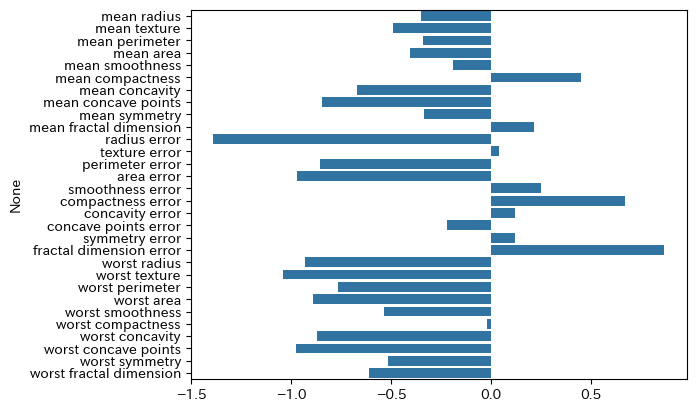

In [ ]:
sns.barplot(x=model.coef_[0], y=X.columns)

回帰係数には正のものと負のものが計算されていることが分かる。


回帰係数は、

* 正であれば、その項目の値が大きくなれば 1 （このデータの場合では良性）になりやすい、

 逆に

* 負であれば、項目の値が大きくなれば 0 （このデータの場合では悪性）になりやすい、

と解釈ができる。

### ロジスティック関数

ロジスティック回帰では、
**ロジスティック関数**を用いて目的変数の値を近似する。

**ロジスティック関数**とは、以下の関数である。
$$ y = \frac{1}{1+ e^{-z}} $$

ただし、
$$ z = a_1 x_1 + a_2 x_2\cdots + a_{30} x_{30} $$
である。

上の $z$ の右辺は重回帰分析で求められた数式と同じ形で、
$x_1, x_2, \ldots, x_{30}$ が30個の変数に対応し、
$a_1, a_2, \ldots, a_{30}$ が回帰係数である。


$z$ を横軸、$y$ を縦軸にとり、ロジスティック関数を可視化した。

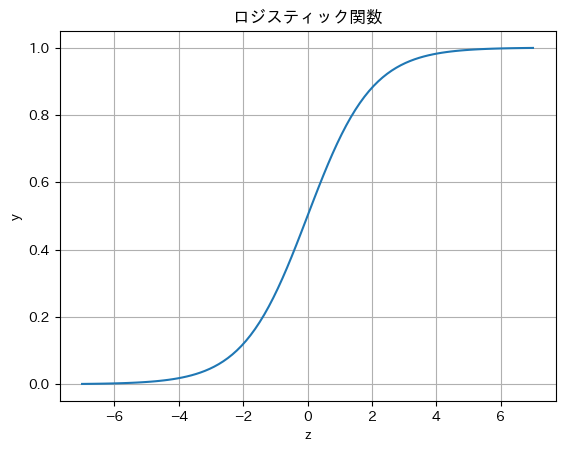

In [ ]:
#@title ロジスティック関数の可視化
import numpy as np
import matplotlib.pyplot as plt

def logistic_function(z):
  return 1 / (1 + np.exp(-z))

# zの値を-7から7まで生成
z = np.linspace(-7, 7, 100)

# ロジスティック関数の値を計算
y = logistic_function(z)

# プロット
plt.plot(z, y)
plt.xlabel('z')
plt.ylabel('y')
plt.title('ロジスティック関数')
plt.grid(True)
plt.show()

この図からも分かるように、ロジスティック関数は $z$ を大きくすると  1 、
小さくすると 0 になる関数である。
すなわち、
目的変数が 1 のデータでは z をできるだけ大きく、
目的変数が 0 のデータでは z をできるだけ小さくするように
回帰係数が計算される。

## 推論

構築したモデルで推論を行うためには、以下のように predict 関数を用いる

```
model.predict(説明変数)
```

predict 関数の内部では z の値が計算され、
0 より大きければ目的変数を 1、
そうでなければ 0 を出力する。

評価用として分割したデータに対して予測を行うためには、以下のようにすればよい。

In [ ]:
from sklearn.metrics import accuracy_score

# 評価データで予測
y_pred = model.predict(X_val_scaled)

学習と同様、説明変数には標準化したものを(X_val_scaled)用いることに注意が必要である。

In [ ]:
y_pred

array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1,
       1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1,
       0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1,
       0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 0, 0, 1])

## 精度の評価

評価用のデータセットを用いて精度の評価を行う。


In [ ]:
compare = y_val.copy()
compare['Pred'] = y_pred
compare

,diagnosis,Pred
512,0,0
457,1,1
439,1,1
298,1,1
37,1,1
...,...,...
213,0,1
519,1,1
432,0,0
516,0,0


diagnosis と Pred を比べ、
予測(Pred)がデータ（医師の判断）と一致していれば
正しく予測できたことになる。

評価基準としては正解率を用いる。

正解率は全体に対する正解したデータ数の割合である。

In [ ]:
from sklearn.metrics import accuracy_score

# 評価データで予測
y_pred = model.predict(X_val_scaled)

# 精度を計算
accuracy = accuracy_score(y_val, y_pred)
accuracy

0.9649122807017544

### 混同行列を使った予測精度の確認

混同行列（confusion matrix）とは、正しく予測できたレコード数や正しく予測できなかったレコード数を集計した、以下のような2行2列の表のことである。


 混同行列   | 0 と予測  | 1 と予測
 -- | --        | --
 正解が 0 のデータ |  A   | B
 正解が 1 のデータ |  C   | D

* A は、0 と予測したレコードの中で正解も 0 であったレコード数
* C は、0 と予測したレコードの中で正解は 1 であったレコード数
* B は、1 と予測したレコードの中で正解は 0 であったレコード数
* D は、1 と予測したレコードの中で正解も 1 であったレコード数

A と D の合計が正しく予測できたレコード数となる。

検証用データの場合で、混同行列を作成する。

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_val, y_pred)

array([[45,  2],
       [ 2, 65]])

したがって、正解率は以下のように計算できる。

（45+65）÷（45+2+2+65）= 0.9649...



---



---



# Titanic データを使った例

今まで説明したロジスティック回帰を、 別のデータに対して実行する。

In [ ]:
# データを読み込む
# 変数名を data とした
data = sns.load_dataset("titanic") #タイタニックのデータ
data.info()
data.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB


,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


##データの説明

列名 | 意味
---  | ---
survived	| 生存フラグ（0=死亡、1=生存）
pclass	| チケットクラス（1stクラス、2ndクラス、3rdクラス）
sex	| 性別（male=男性、female＝女性）
sge	| 年齢
sibsp	| タイタニックに同乗している兄弟/配偶者の数
parch	| タイタニックに同乗している親/子供の数
fare	| 料金
embarked	| 出港地（タイタニックへ乗った港）(C=Cherbourg、Q=Queenstown、S=Southampton)
class | 乗船クラス
who |男性 or 女性
adult_male | 成人男性であるかどうか
deck | 乗船していたデッキ
embark_town | 出港地
alive | 生存したかどうか
alone | 一人であったかどうか

In [ ]:
# 欠損値を確認する
data.isnull().sum()

,0
survived,0
pclass,0
sex,0
age,177
sibsp,0
parch,0
fare,0
embarked,2
class,0
who,0


In [ ]:
# 欠損値を埋める

# 平均値で欠損値を埋める。
data['age'] = data['age'].fillna(data['age'].mean())

# 最頻値で欠損値を埋める。
data['embarked'] = data['embarked'].fillna(data['embarked'].mode()[0])
data['embark_town'] =  data['embark_town'].fillna(data['embark_town'].mode()[0])

# 結果を確認
data.isnull().sum()

,0
survived,0
pclass,0
sex,0
age,0
sibsp,0
parch,0
fare,0
embarked,0
class,0
who,0


         survived      pclass         age       sibsp       parch        fare
count  891.000000  891.000000  891.000000  891.000000  891.000000  891.000000
mean     0.383838    2.308642   29.699118    0.523008    0.381594   32.204208
std      0.486592    0.836071   13.002015    1.102743    0.806057   49.693429
min      0.000000    1.000000    0.420000    0.000000    0.000000    0.000000
25%      0.000000    2.000000   22.000000    0.000000    0.000000    7.910400
50%      0.000000    3.000000   29.699118    0.000000    0.000000   14.454200
75%      1.000000    3.000000   35.000000    1.000000    0.000000   31.000000
max      1.000000    3.000000   80.000000    8.000000    6.000000  512.329200

生存者数と死亡者数の集計:
survived
0    549
1    342
Name: count, dtype: int64

クラスごとの生存率:
pclass
1    0.629630
2    0.472826
3    0.242363
Name: survived, dtype: float64

性別ごとの生存率:
sex
female    0.742038
male      0.188908
Name: survived, dtype: float64

年齢の分布:
Axes(0.125,0.11;0.775x0.77)


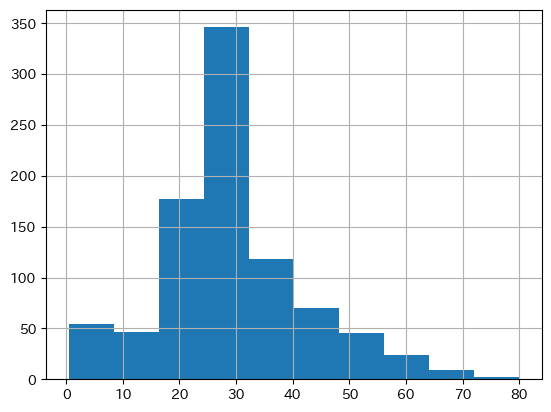

In [ ]:
# 基本的な統計情報を表示
print(data.describe())

# 生存者数と死亡者数を集計
survived_counts = data['survived'].value_counts()
print("\n生存者数と死亡者数の集計:")
print(survived_counts)

# 乗客のクラスごとの生存率を計算
survival_rate_by_class = data.groupby('pclass')['survived'].mean()
print("\nクラスごとの生存率:")
print(survival_rate_by_class)

# 性別ごとの生存率を計算
survival_rate_by_gender = data.groupby('sex')['survived'].mean()
print("\n性別ごとの生存率:")
print(survival_rate_by_gender)

# 年齢の分布を表示
print("\n年齢の分布:")
print(data['age'].hist())

In [ ]:
# 説明変数と目的変数を選択
# 数値データのみで予測
X = data[[ 'age', 'fare', 'sibsp', 'parch']]
y = data['survived']

Accuracy: 0.6815642458100558


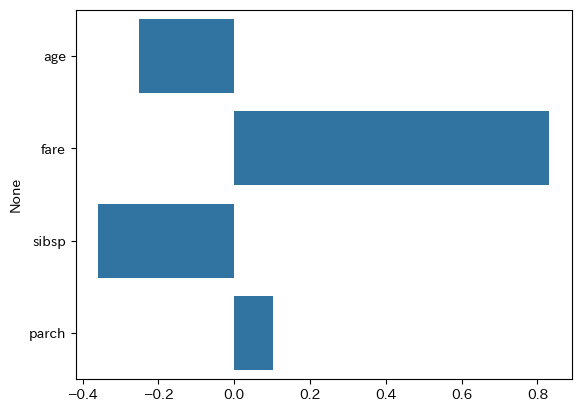

In [ ]:
# データを学習用と検証用に分割
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 準備のための手順
scaler = StandardScaler()
scaler.fit(X_train)

# 標準化後のものは別の変数にセットすると良い
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)

# ロジスティック回帰モデルを作成
model = LogisticRegression()

# モデルを訓練
model.fit(X_train_scaled, y_train)

# テストデータで予測
y_pred = model.predict(X_val_scaled)

# 精度を計算
accuracy = accuracy_score(y_val, y_pred)
print(f'Accuracy: {accuracy}')

# 回帰係数を可視化
sns.barplot(x=model.coef_[0], y=X.columns)
plt.show()

In [ ]:
# カテゴリ変数をOne Hot Encoding
data_encoded = pd.get_dummies(data[['embarked', 'class', 'who', 'adult_male', 'alone']], drop_first=True)

# 説明変数と目的変数を設定
X = pd.concat([data[['age', 'fare', 'sibsp', 'parch']], data_encoded], axis=1)
y = data['survived']

Accuracy: 0.8100558659217877


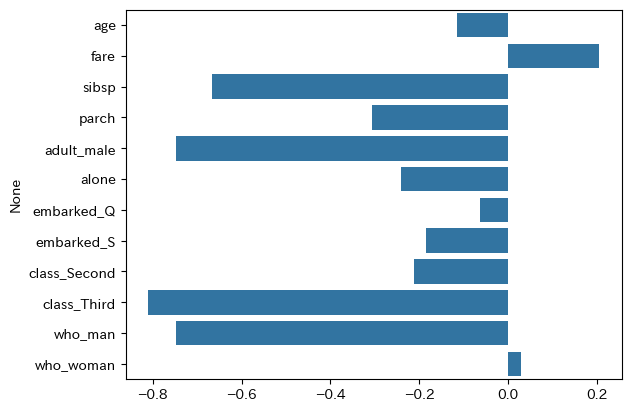

In [ ]:
# データを訓練セットとテストセットに分割
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 準備のための手順
scaler = StandardScaler()
scaler.fit(X_train)

# 標準化後のものは別の変数にセットすると良い
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)

# ロジスティック回帰モデルを作成
model = LogisticRegression()

# モデルを訓練
model.fit(X_train_scaled, y_train)

# テストデータで予測
y_pred = model.predict(X_val_scaled)

# 精度を計算
accuracy = accuracy_score(y_val, y_pred)
print(f'Accuracy: {accuracy}')

# 特徴量の重要度を可視化
sns.barplot(x=model.coef_[0], y=X.columns)
plt.show()

---
---
---


# 発展的な課題

以下のサイトにあるデータを使い、
各自で分類を行うモデルを作成してみよ。

https://www.kaggle.com/datasets/jsphyg/weather-dataset-rattle-package

https://www.kaggle.com/datasets/yeanzc/telco-customer-churn-ibm-dataset